In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import linregress, spearmanr, kendalltau
from sklearn.feature_selection import mutual_info_regression
import numpy as np

In [6]:
# Load datasets
train_path = 'input/train.csv'
test_path='input/test.csv'
train_df = pd.read_csv(train_path)
test_df = pd.read_csv(test_path)
model_df = train_df.copy()
numeric_columns = model_df.select_dtypes(include=['int64','float64']).columns

model_df=model_df.fillna(model_df[numeric_columns].mean().to_dict())
train_df.head()

train_target = train_df['price_doc']

### pca
since we have a lot of highly correlated features we want to reduce the amount of them. 

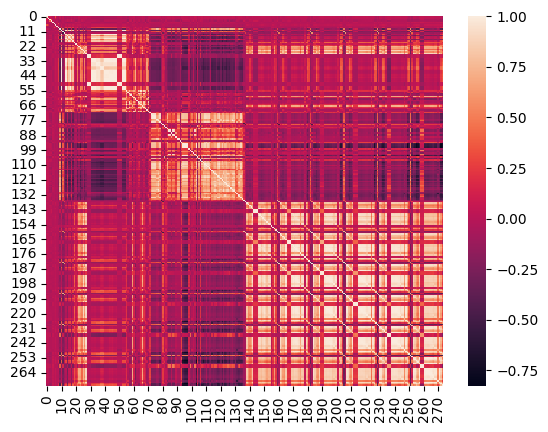

<Axes: >

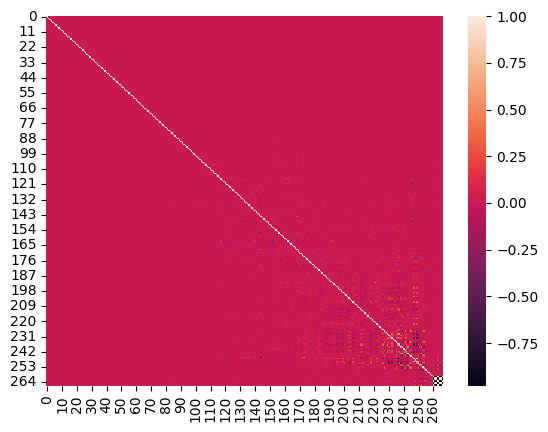

In [7]:
from sklearn.decomposition import PCA 
pca = PCA(n_components="mle",svd_solver='auto')
train_pca=pca.fit_transform(model_df.select_dtypes(include=["int64","float64"]))
(train_pca.shape,model_df.shape)
sns.heatmap(np.corrcoef(model_df.drop(['id','price_doc'],axis=1).select_dtypes(include=["int64","float64"]),rowvar=False))
plt.show()
sns.heatmap(np.corrcoef(train_pca,rowvar=False))

# regularization for feature selection
oopsie doopsie, PCA gives us orthogonal features, so we can't assess the colinearity problem! let's use regularization instead 

<Axes: >

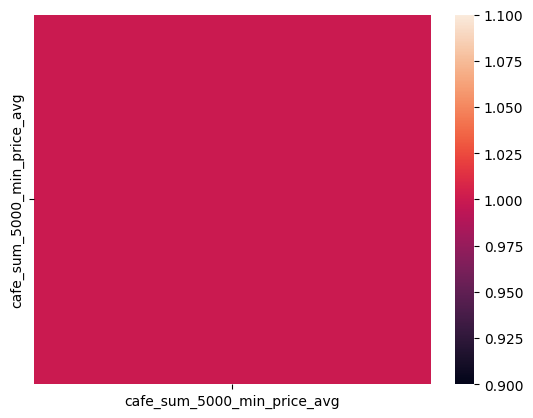

In [8]:
from sklearn.linear_model import ElasticNetCV
elastic_net = ElasticNetCV()
threshold = 0
elastic_net.fit(model_df.select_dtypes(include=["int64","float64"]),np.log(model_df['price_doc']))
subset = model_df[model_df.columns[np.where(elastic_net.coef_>threshold)]]
sns.heatmap(subset.corr())

# manual filtering
well sadly as we can see regularization is way too harsh. instead we will check for correlation and filter using a manual threshold

In [9]:

def clean_real_estate_data(df, is_train=True):
    """Cleans real estate dataset by applying multiple data consistency rules."""
    
    # Ensure 'life_sq' is not greater than 'full_sq'
    df.loc[df.life_sq > df.full_sq, "life_sq"] = np.nan
    
    # Specific index fixes
    if not is_train:
        df.loc[[601, 1896, 2791], "life_sq"] = df.loc[[601, 1896, 2791], "full_sq"]

    # Set unrealistic 'life_sq' and 'full_sq' values to NaN
    df.loc[df.life_sq < 5, "life_sq"] = np.nan
    df.loc[df.full_sq < 5, "full_sq"] = np.nan
    
    # Special case for 'build_year'
    if is_train:
        df.loc[[13117], "build_year"] = df.loc[[13117], "kitch_sq"]

    # Ensure 'kitch_sq' is reasonable
    df.loc[df.kitch_sq >= df.life_sq, "kitch_sq"] = np.nan
    df.loc[df.kitch_sq.isin([0, 1]), "kitch_sq"] = np.nan
    
    # Handle unrealistic proportions in 'life_sq' vs 'full_sq'
    df.loc[(df.full_sq > (210 if is_train else 150)) & (df.life_sq / df.full_sq < 0.3), "full_sq"] = np.nan
    
    # Cap very large 'life_sq' values
    df.loc[df.life_sq > (300 if is_train else 200), ["life_sq", "full_sq"]] = np.nan
    
    # Remove unrealistic 'build_year' values
    df.loc[df.build_year < 1500, "build_year"] = np.nan
    
    # Remove zero room values
    df.loc[df.num_room == 0, "num_room"] = np.nan

    # Specific index-based num_room adjustments
    if is_train:
        df.loc[[10076, 11621, 17764, 19390, 24007, 26713, 29172], "num_room"] = np.nan
    else:
        df.loc[[3174, 7313], "num_room"] = np.nan

    # Handle 'floor' and 'max_floor' inconsistencies
    df.loc[(df.floor == 0) & (df.max_floor == 0), ["max_floor", "floor"]] = np.nan
    df.loc[df.floor == 0, "floor"] = np.nan
    df.loc[df.max_floor == 0, "max_floor"] = np.nan
    df.loc[df.floor > df.max_floor, "max_floor"] = np.nan

    # Specific index-based floor adjustment
    if is_train:
        df.loc[[23584], "floor"] = np.nan

    # Remove invalid 'state' values
    df.loc[df.state == 33, "state"] = np.nan

    return df

In [198]:
import numpy as np
import pandas as pd

def clean_and_magic(df, is_train: bool):
    """Cleans and preprocesses the given DataFrame.

    Args:
        df (pd.DataFrame): The input DataFrame (either train or test).
        is_train (bool): Whether the input DataFrame is the training set.

    Returns:
        pd.DataFrame: The cleaned and processed DataFrame.
    """
    # Fix life_sq > full_sq issue
    df.loc[df.life_sq > df.full_sq, "life_sq"] = np.nan

    # Specific fixes (only for test dataset, if applicable)
    # if not is_train:
    equal_index = [601, 1896, 2791]
    df.loc[equal_index, "life_sq"] = df.loc[equal_index, "full_sq"]

    # if is_train:
    df.loc[df['build_year'].isin([2,3,20,71,215]), 'build_year'] = np.nan
    df.loc[df['build_year'] == 4965, 'build_year'] = 1956
    df.loc[df['build_year'] == 1691, 'build_year'] = 1961
    # df.loc[df['build_year']>2016,'build_year']=np.nan
    
    df.loc[df['id'].isin([10092]), 'build_year'] = 2009

    df.loc[df.full_sq == 5326.0, 'full_sq'] = 53
    df.loc[df.life_sq == 2, 'life_sq'] = np.nan
    df.loc[df.life_sq == 7478.0, 'life_sq'] = 48

    # Remove unrealistic values
    df.loc[df.life_sq < 5, "life_sq"] = np.nan
    df.loc[df.full_sq < 5, "full_sq"] = np.nan
    df.loc[df.kitch_sq >= df.life_sq, "kitch_sq"] = np.nan
    df.loc[(df.kitch_sq == 0) | (df.kitch_sq == 1), "kitch_sq"] = np.nan
    df.loc[df.floor > df.max_floor, "max_floor"] = np.nan
    df.loc[df.max_floor == 0, "max_floor"] = np.nan

    # Specific corrections for build year
    df.loc[df.build_year < 1500, "build_year"] = np.nan

    # Room numbers
    df.loc[df.num_room == 0, "num_room"] = np.nan

    # Floor values
    df.loc[df.floor == 0, "floor"] = np.nan

    # State corrections
    df.loc[df.state == 33, "state"] = np.nan

    # Feature Engineering
    # df['month_year_cnt'] = df.timestamp.dt.month + df.timestamp.dt.year * 100
    # df['week_year_cnt'] = df.timestamp.dt.isocalendar().week + df.timestamp.dt.year * 100
    # df['dow'] = df.timestamp.dt.dayofweek
    df['rel_floor'] = df['floor'] / df['max_floor'].astype(float)
    df['rel_kitch_sq'] = df['kitch_sq'] / df['full_sq'].astype(float)
    df['room_size'] = df['life_sq'] / df['num_room'].astype(float)

    df['apartment_name'] = pd.factorize(df.sub_area + df['metro_km_avto'].astype(str))[0]
    df['year'] = pd.DatetimeIndex(df['timestamp']).year
    df['month'] = pd.DatetimeIndex(df['timestamp']).month
    df['week'] = df['timestamp'].dt.isocalendar().week
    df['dow'] = df['timestamp'].dt.dayofweek
    # index of current atractivity
    
    # high-ish res
    df['activity_highish_local'] =  df[['apartment_name','year','month']].apply(tuple,axis=1).map(df.groupby(['apartment_name','year','month']).size())
    df['activity_highish_regional'] =  df[['sub_area','year','month']].apply(tuple,axis=1).map(df.groupby(['sub_area','year','month']).size())
    # low-ish res
    df['activity_lowish_local'] =  df[['apartment_name','year','week']].apply(tuple,axis=1).map(df.groupby(['apartment_name','year','week']).size())
    df['activity_lowish_regional'] =  df[['sub_area','year','week']].apply(tuple,axis=1).map(df.groupby(['sub_area','year','week']).size())
    
    # general activity
    df['activity_highish_general'] =  df[['year','month']].apply(tuple,axis=1).map(df.groupby(['year','month']).size())
    df['activity_lowish_general'] =  df[['year','week']].apply(tuple,axis=1).map(df.groupby(['year','week']).size())
    
    df = df.drop('apartment_name',axis=1)
    # Quarterly price normalization (only for training dataset)

    rate_map={
    '2016_q2': 1,
    '2016_q1': 1.0009709418135593,
    '2015_q4': 1.0181781525923703,
    '2015_q3': 1.0353652151640942,
    '2015_q2': 1.054880504497294,
    '2015_q1': 1.0621028035615123,
    '2014_q4': 1.050339006686622,
    '2014_q3': 1.0328832792670097,
    '2014_q2': 1.0240762237428216,
    '2014_q1': 1.011333422617837,
    '2013_q4': 1.0213425799008655,
    '2013_q3': 1.0171721739875168,
    '2013_q2': 1.0127162226080415,
    '2013_q1': 1.0022923818369374,
    '2012_q4': 1.0194186145615718,
    '2012_q3': 0.9919418259818739,
    '2012_q2': 0.9650178285649128,
    '2012_q1': 0.9388246216216682,
    '2011_q4': 0.8725135888677213,
    '2011_q3': 0.8523970192142647,
    '2011_q2': 0.8523970192142647,
    '2011_q1': 0.8431226698459592
}

    df['average_q_price'] = df['timestamp'].apply(lambda x:'{0}_q{1}'.format(x.year,(x.month-1)//4+1)).map(rate_map)
    # df['price_doc'] = df['price_doc'] * df['average_q_price']

    return df

In [214]:
train_clean = (model_df.copy()
               .drop([c for c in train_df.columns if c.startswith('ID')], axis=1)
                )

train_clean['timestamp'] = pd.DatetimeIndex(train_clean['timestamp'])
# train_clean = clean_real_estate_data(train_clean, is_train=True)
train_clean = clean_and_magic(train_clean, is_train=True)

# some stupid fixes

train_clean['build_year'].fillna(train_clean.groupby(['sub_area', 'max_floor'])['build_year'].
                               transform('median'), inplace=True)
train_clean['build_year'].fillna(train_clean.groupby(['sub_area'])['build_year'].
                            transform('median'), inplace=True)

train_clean = train_clean.drop(columns=['id'])

# # normalize
# numerical = train_clean.select_dtypes(include=['float64', 'int64']).drop(['id','price_doc'],axis=1)
# train_clean[numerical.columns]=(numerical-numerical.mean(axis=0))/numerical.std(axis=0)

# names = train_clean['sub_area'] + train_clean['metro_km_avto'].apply(lambda x: np.round(x)).astype(str)


print(train_clean.select_dtypes(include=['float64', 'int64']).shape)
# train_clean['building_name'] = pd.factorize(train_clean.sub_area + train_clean['metro_km_avto'].astype(str))[0]

def correlation(dataset, threshold):
    col_corr = set() # Set of all the names of deleted columns
    corr_matrix = dataset.select_dtypes(include=['float64','int64']).corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j] >= threshold) and (corr_matrix.columns[j] not in col_corr):
                colname = corr_matrix.columns[i] # getting the name of column
                col_corr.add(colname)
                break
    return col_corr

correlated_columns= correlation(train_clean,0.9)
# train_clean = train_clean.drop(columns=correlated_columns)
print(train_clean.shape)


train_clean=train_clean.drop(['timestamp'],axis=1)

# create some custom features

# train_clean[['room_size','rel_floor']] = train_clean[['room_size','rel_floor']].replace(np.inf,np.nan).fillna(train_clean[['room_size','rel_floor']].median())

# more general fill
train_clean['full_sq']=train_clean['full_sq'].fillna(50)


# train_clean['_apartment_name_drop'] = names
# train_clean.life_sq.\
#     fillna(train_clean.groupby(['_apartment_name_drop'])['life_sq'].transform("median"), inplace=True)
# train_clean.full_sq.\
#     fillna(train_clean.groupby(['_apartment_name_drop'])['full_sq'].transform("median"), inplace=True)

# train_clean = train_clean.drop('apartment_name',axis=1)

# there are way too many sub_areas for normal dummies
for factorized_column in ['sub_area','product_type']:
    train_clean[factorized_column] = pd.factorize(train_clean[factorized_column])[0]


# for col in ['sub_area','material','ecology']:
#     train_clean[col]=LabelEncoder().fit_transform(train_clean[col])

train_clean['year_from_start']=train_clean['year']-train_clean['year'].min()
categorical = train_clean.select_dtypes(include=['object', 'category']).columns.append(pd.Index(['year']))



print(categorical)
# for c in categorical:
    # train_clean[c]=pd.factorize(train_clean[c])[0]
train_clean = pd.get_dummies(train_clean,columns=categorical,drop_first=True,prefix='dummy_'+categorical,dtype='int64')

majority = train_clean["price_doc"].quantile([0.025,0.975])
# remove outliers
print(f'price_doc 95\% between {list(majority)}')
train_clean=train_clean.loc[train_clean['price_doc'].between(*majority),:]
print(train_clean.shape)
print(train_clean[train_clean.price_doc/train_clean.full_sq <= 600000].shape)
print(train_clean[train_clean.price_doc/train_clean.full_sq >= 10000].shape)
train_clean = train_clean[train_clean.price_doc/train_clean.full_sq <= 600000]
train_clean = train_clean[train_clean.price_doc/train_clean.full_sq >= 10000]

train_clean['dummy_year_2016']=np.zeros_like(train_clean['price_doc'])
print(train_clean.shape)

C:\Users\yonatan.rubin\AppData\Local\Temp\ipykernel_30256\1827668388.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_clean['build_year'].fillna(train_clean.groupby(['sub_area', 'max_floor'])['build_year'].
C:\Users\yonatan.rubin\AppData\Local\Temp\ipykernel_30256\1827668388.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object o

(30471, 278)
(30471, 298)
Index(['culture_objects_top_25', 'thermal_power_plant_raion',
       'incineration_raion', 'oil_chemistry_raion', 'radiation_raion',
       'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion',
       'detention_facility_raion', 'water_1line', 'big_road1_1line',
       'railroad_1line', 'ecology', 'year'],
      dtype='object')
price_doc 95\% between [1000000.0, 17822718.0]
(29476, 304)
(29473, 304)
(29468, 304)
(29465, 305)


In [215]:
test_clean = (test_df.copy()
               .drop([c for c in test_df.columns if c.startswith('ID')], axis=1)
                )

test_clean['timestamp'] = pd.DatetimeIndex(test_clean['timestamp'])
# test_clean = clean_real_estate_data(test_clean, is_test=True)
test_clean = clean_and_magic(test_clean, is_train=False)

# some stupid fixes

test_clean['build_year'].fillna(test_clean.groupby(['sub_area', 'max_floor'])['build_year'].
                               transform('median'), inplace=True)
test_clean['build_year'].fillna(test_clean.groupby(['sub_area'])['build_year'].
                            transform('median'), inplace=True)

test_ids=test_df['id']

print(test_clean.select_dtypes(include=['float64', 'int64']).shape)
# test_clean['building_name'] = pd.factorize(test_clean.sub_area + test_clean['metro_km_avto'].astype(str))[0]

# test_clean = test_clean.drop(columns=correlated_columns)
print(test_clean.shape)

test_clean=test_clean.drop(['timestamp','id'],axis=1)

# create some custom features
# test_clean['after_2015']=test_clean['year']>=2015

# test_clean[['room_size','rel_floor']] = test_clean[['room_size','rel_floor']].replace(np.inf,np.nan).fillna(test_clean[['room_size','rel_floor']].median())

# more general fill
test_clean['full_sq']=test_clean['full_sq'].fillna(50)
test_clean['product_type']=test_clean['product_type'].fillna('Investment')


# test_clean['_apartment_name_drop'] = names
# test_clean.life_sq.\
#     fillna(test_clean.groupby(['_apartment_name_drop'])['life_sq'].transform("median"), inplace=True)
# test_clean.full_sq.\
#     fillna(test_clean.groupby(['_apartment_name_drop'])['full_sq'].transform("median"), inplace=True)

# test_clean = test_clean.drop('apartment_name',axis=1)

# there are way too many sub_areas for normal dummies
for factorized_column in ['sub_area','product_type']:
    test_clean[factorized_column] = pd.factorize(test_clean[factorized_column])[0]


# for col in ['sub_area','material','ecology']:
#     test_clean[col]=LabelEncoder().fit_transform(test_clean[col])

test_clean['year_from_start']=test_clean['year']-test_clean['year'].min()
categorical = test_clean.select_dtypes(include=['object', 'category']).columns.append(pd.Index(['year']))

print(categorical)
# for c in categorical:
    # test_clean[c]=pd.factorize(test_clean[c])[0]
test_clean = pd.get_dummies(test_clean,columns=categorical,drop_first=True,prefix='dummy_'+categorical,dtype='int64')

test_clean[['dummy_year_2012', 'dummy_year_2013', 'dummy_year_2014',
       'dummy_year_2015']]=np.zeros(shape=[test_clean.shape[0],4])

print(test_clean.shape)

print(test_clean.columns.symmetric_difference(train_clean.columns))

(7662, 278)
(7662, 298)
Index(['culture_objects_top_25', 'thermal_power_plant_raion',
       'incineration_raion', 'oil_chemistry_raion', 'radiation_raion',
       'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion',
       'detention_facility_raion', 'water_1line', 'big_road1_1line',
       'railroad_1line', 'ecology', 'year'],
      dtype='object')
(7662, 304)
Index(['price_doc'], dtype='object')


C:\Users\yonatan.rubin\AppData\Local\Temp\ipykernel_30256\1502359691.py:11: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  test_clean['build_year'].fillna(test_clean.groupby(['sub_area', 'max_floor'])['build_year'].
C:\Users\yonatan.rubin\AppData\Local\Temp\ipykernel_30256\1502359691.py:13: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on 

# combining data sets
there might be a problem with the factorization of the two datasets seperatly.
To handle this we can run the entire cleaning over one df

In [253]:
test_ids=test_df['id']

total_clean = pd.concat([train_df,test_df]).drop([c for c in test_df.columns if c.startswith('ID')], axis=1)
total_clean['timestamp'] = pd.DatetimeIndex(total_clean['timestamp'])
total_clean = clean_and_magic(total_clean, is_train=False)

# some stupid fixes
total_clean['build_year'].fillna(total_clean.groupby(['sub_area', 'max_floor'])['build_year'].
                               transform('median'), inplace=True)
total_clean['build_year'].fillna(total_clean.groupby(['sub_area'])['build_year'].
                            transform('median'), inplace=True)

print(total_clean.select_dtypes(include=['float64', 'int64']).shape)
# total_clean['building_name'] = pd.factorize(total_clean.sub_area + total_clean['metro_km_avto'].astype(str))[0]

# total_clean = total_clean.drop(columns=correlated_columns)
print(total_clean.shape)

total_clean=total_clean.drop(['timestamp'],axis=1)

# more general fill
total_clean['full_sq']=total_clean['full_sq'].fillna(50)
total_clean['product_type']=total_clean['product_type'].fillna('Investment')


# total_clean.life_sq.\
#     fillna(total_clean.groupby(['_apartment_name_drop'])['life_sq'].transform("median"), inplace=True)
# total_clean.full_sq.\
#     fillna(total_clean.groupby(['_apartment_name_drop'])['full_sq'].transform("median"), inplace=True)

# correlated_columns= correlation(total_clean,0.9)
# train_clean = train_clean.drop(columns=correlated_columns)

# there are way too many sub_areas for normal dummies
for factorized_column in ['sub_area','product_type']:
    total_clean[factorized_column] = pd.factorize(total_clean[factorized_column])[0]


# for col in ['sub_area','material','ecology']:
#     total_clean[col]=LabelEncoder().fit_transform(total_clean[col])

total_clean['year_from_start']=total_clean['year']-total_clean['year'].min()
categorical = total_clean.select_dtypes(include=['object', 'category']).columns.append(pd.Index(['year']))

print(categorical)
# for c in categorical:
    # total_clean[c]=pd.factorize(total_clean[c])[0]
total_clean = pd.get_dummies(total_clean,columns=categorical,drop_first=True,prefix='dummy_'+categorical,dtype='int64')

print(total_clean.shape)

train_clean = total_clean.iloc[:-len(test_ids),:].drop(columns=['id'])
test_clean = total_clean.iloc[-len(test_ids):,:].drop(columns=['id','price_doc'])

train_clean = train_clean[train_clean.price_doc.between(
                            *train_clean.price_doc.quantile([0.025,0.975])
                            )&(train_clean.price_doc/train_clean.full_sq).between(10000,600000)]

print(test_clean.shape)

C:\Users\yonatan.rubin\AppData\Local\Temp\ipykernel_30256\2233183551.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  total_clean['build_year'].fillna(total_clean.groupby(['sub_area', 'max_floor'])['build_year'].
C:\Users\yonatan.rubin\AppData\Local\Temp\ipykernel_30256\2233183551.py:10: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on

(38133, 279)
(38133, 299)
Index(['culture_objects_top_25', 'thermal_power_plant_raion',
       'incineration_raion', 'oil_chemistry_raion', 'radiation_raion',
       'railroad_terminal_raion', 'big_market_raion', 'nuclear_reactor_raion',
       'detention_facility_raion', 'water_1line', 'big_road1_1line',
       'railroad_1line', 'ecology', 'year'],
      dtype='object')
(38133, 306)
(7662, 304)


In [12]:
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, RegressorMixin
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.compose import TransformedTargetRegressor
class TargetValueTransformer(TransformedTargetRegressor):
    def __init__(
        self,
        regressor=None,
        *,
        transformer=None,
        func=None,
        inverse_func=None,
        check_inverse=False,
    ):        
        super(TargetValueTransformer, self).__init__(regressor,        
        transformer=transformer,
        func=func,
        inverse_func=inverse_func,
        check_inverse=check_inverse,
)
      
    def _fit_transformer(self, y):
        pass
        
    def fit(self, X, y):
        self.regressor.fit(X, self.func(X, y))
        return self
    
    def predict(self, X):
        return self.inverse_func(X, self.regressor.predict(X))

class TargetValueResturctueTransformer(TransformedTargetRegressor):
    def __init__(
        self,
        regressor=None,
        *,
        transformer=None,
        func=None,
        inverse_func=None,
        check_inverse=False,
        restructure_func = None
    ):        
        super().__init__(regressor,        
        transformer=transformer,
        func=func,
        inverse_func=inverse_func,
        check_inverse=check_inverse,)
        self.restructure_func = restructure_func
      
    def _fit_transformer(self, y):
        pass
        
    def fit(self, X, y):
        y =  self.func(X, y)
        if self.restructure_func:
            X = self.restructure_func(X)
        self.regressor.fit(X,y)
        return self
    
    def predict(self, X):
        predict_X = X 
        if self.restructure_func:
            predict_X = self.restructure_func(X)
        return self.inverse_func(X, self.regressor.predict(predict_X))

def transform(X,y):
    transformed = np.log(y/(X['full_sq']))
    return transformed

def inverse_transform(X,y):
    transformed = np.exp(y)*(X['full_sq'])
    return transformed

In [16]:
from sklearn.linear_model import Lasso, Ridge
from sklearn.metrics import  root_mean_squared_log_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

X,Y = train_clean.drop(['price_doc'],axis=1),train_clean['price_doc'] 

X=X.fillna(X.mean())

Xtrain,Xtest,Ytrain,Ytest = train_test_split(X,Y)
pipe = TargetValueTransformer(Pipeline([
    ('scaler', StandardScaler()),
    ('model', Ridge())
    ]),
    func=transform,
    inverse_func=inverse_transform
)
pipe.fit(Xtrain,Ytrain)

predict=pipe.predict(Xtest)
root_mean_squared_log_error(y_pred=predict,y_true=Ytest)

np.float64(3.281927921133565)

In [31]:
### How will the regularization model cope now?
from sklearn.model_selection import GridSearchCV, KFold, ShuffleSplit, cross_validate
from sklearn.decomposition import PCA 
splitter = KFold(shuffle=True)
model_lasso = TargetValueTransformer(
    Pipeline([('scaler',StandardScaler()),
              ('pca',PCA()),
              ('lasso',Lasso())]),
    func=transform,
    inverse_func=inverse_transform
    )

parameters = {
    # 'regressor__pca__n_components':np.arange(15,156,10),
    'regressor__lasso__alpha': np.arange(0.01,1,step=0.1)
}

print(parameters)
X,Y = train_clean.drop('price_doc',axis=1),train_clean['price_doc']
X=X.fillna(X.mean())
grid_search = GridSearchCV(model_lasso, parameters,
                                scoring='neg_root_mean_squared_log_error',
                                cv=splitter,
                                return_train_score=True,
                                n_jobs=-1,
                                verbose=10
                                ).fit(X,Y)
model_lasso.set_params(**grid_search.best_params_)

{'regressor__lasso__alpha': array([0.01, 0.11, 0.21, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91])}
Fitting 5 folds for each of 10 candidates, totalling 50 fits


TargetValueTransformer(func=<function transform at 0x000002CA17256A20>,
                       inverse_func=<function inverse_transform at 0x000002CA172E1620>,
                       regressor=Pipeline(steps=[('scaler', StandardScaler()),
                                                 ('pca', PCA()),
                                                 ('lasso',
                                                  Lasso(alpha=np.float64(0.01)))]))

In [32]:
print(grid_search.best_params_)
grid_search.best_score_

{'regressor__lasso__alpha': np.float64(0.01)}


np.float64(-0.4539462194648144)

In [19]:
# from sklearn.model_selection import RandomizedSearchCV
# import xgboost as xgb

# xgb_model = xgb.XGBRFRegressor()
# splitter = KFold(shuffle=True)
# xgb_pipe = TargetValueTransformer(Pipeline([
#     ('scaler',StandardScaler()),
#     # ('pca',PCA()),
#     ('xgb',xgb_model)
#     ]),
#     func=transform,
#     inverse_func=inverse_transform,
# )
# X,Y = train_clean.drop('price_doc',axis=1),train_clean['price_doc']
# for parameters in [
#     # {
#     # 'pca__n_components':np.arange(15,156,10)
#     # },
#     {
#             "xgb__max_depth" : np.arange(5,17,2),
#             # "xgb__min_samples_leaf":np.arange(100,1000,250), 
#            }
#     ]:
#     print(f'tuning:{list(parameters.keys())}')
#     parameters = {'regressor__'+key: value for key,value in parameters.items()}
#     print(parameters)
#     grid_search = GridSearchCV(xgb_pipe, parameters,
#                                     scoring='neg_root_mean_squared_log_error',
#                                     cv=splitter,
#                                     n_jobs=-1,verbose=10).fit(X,Y)
#     print(grid_search.best_params_)
#     xgb_pipe.set_params(**grid_search.best_params_)
# pd.DataFrame(cross_validate(grid_search.best_estimator_,X,Y,cv=splitter,scoring='neg_root_mean_squared_log_error')).mean()

tuning:['xgb__max_depth']
{'regressor__xgb__max_depth': array([ 5,  7,  9, 11, 13, 15])}
Fitting 5 folds for each of 6 candidates, totalling 30 fits


KeyboardInterrupt: 

In [ ]:
# pd.DataFrame(grid_search.cv_results_)
split = TargetValueTransformer(grid_search.best_estimator_,func=transform,inverse_func=inverse_transform)
res=cross_validate(split,X,Y,cv=splitter,scoring='neg_root_mean_squared_log_error')

c:\Users\yonatan.rubin\code\PERSONAL\ML_final\venv\Lib\site-packages\xgboost\training.py:182: UserWarning: [10:46:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:44: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\yonatan.rubin\code\PERSONAL\ML_final\venv\Lib\site-packages\xgboost\training.py:182: UserWarning: [10:46:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:197: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\yonatan.rubin\code\PERSONAL\ML_final\venv\Lib\site-packages\xgboost\training.py:182: UserWarning: [10:46:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\context.cc:44: No visible GPU is found, setting device to CPU.
  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\yonatan.rubin\code\PERSONAL\ML_final\venv\Lib\site-packages\xgboost\training.py:182: UserWarning: [10:46:16] WARNING: C:\actions-runner\_work\xgboost\xgboost\src

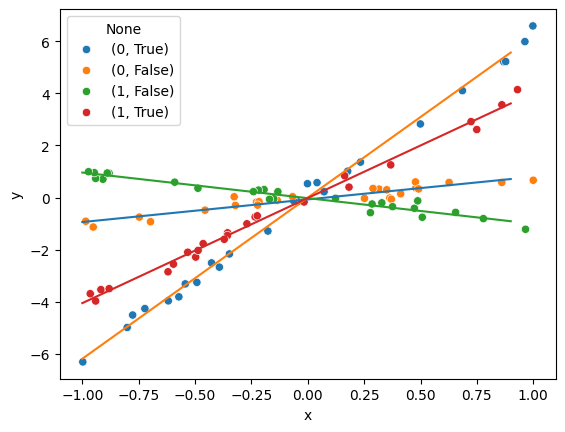

In [33]:
from collections import defaultdict
from itertools import product
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

class ModelsByParameter(BaseEstimator):
    def __init__(self,split:BaseEstimator,column,split_false:BaseEstimator=None):
        self.split=split
        self.split_true = split
        if split_false is None:
            split_false = sklearn.base.clone(split)
        self.split_false = split_false
        self.column = column
    
    def fit(self,X,y):
        indices = X[self.column]==1
        X_true,y_true = X.loc[indices,:],y[indices]
        X_false,y_false= X.loc[~indices,:],y[~indices]
        self.split_true.fit(X_true,y_true)
        self.split_false.fit(X_false,y_false)

    def predict(self,X):
        predict = np.zeros(shape=X.shape[0])
        indices = X[self.column]==1
        if np.any(indices):
            predict[indices] = self.split_true.predict(X.loc[indices,:])
        if np.any(~indices):
            predict[~indices] = self.split_false.predict(X.loc[~indices,:])
        return predict

class ModelsByGroupParameter(BaseEstimator):
    def __init__(self,split:BaseEstimator,selector):
        self.split=split
        self.models = defaultdict(lambda:sklearn.base.clone(split))
        self.selector = selector
    
    def fit(self,X,y):
        for value,group in X.groupby(self.selector):
            X_true,y_true = group,y[group.index]
            self.models[value].fit(X_true,y_true)

    def predict(self,X):
        predict = np.zeros(shape=X.shape[0])
        for value,group in X.groupby(self.selector):
            if np.any(group):
                pos_indices = X.index.get_indexer(group.index)
                predict[pos_indices] = self.models[value].predict(group)
        return predict

X = pd.DataFrame({'x':np.random.uniform(-1,1,100)})
X['flag'] = (np.arange(100)>50).astype(int)
X['flag2'] =  np.logical_or(np.arange(100)<25,np.arange(100)>75)
X['y'] = (1+-2*X['flag']+5*X['flag2'])*X['x']+np.random.normal(0,0.2,100)

ax=sns.scatterplot(X,x='x',y='y',hue=X[['flag','flag2']].apply(tuple,axis=1))

m=GridSearchCV(
    ModelsByGroupParameter(
        LinearRegression(),
        selector=['flag','flag2']),{
    'split__fit_intercept':[False,True]
},scoring='neg_mean_squared_error')
m.fit(X.drop(columns='y'),X['y'])

predicted_line = pd.DataFrame({'x':np.arange(-1,1,step=0.1)})
for combination in product([0,1],[0,1]):
    predicted_line['flag']=np.repeat(combination[0],predicted_line['x'].shape)
    predicted_line['flag2']=np.repeat(combination[1],predicted_line['x'].shape)
    p=m.predict(predicted_line)
    ax.plot(predicted_line['x'],p)
# predicted_line['flag']=np.ones_like(predicted_line['x'])
# p=m.predict(predicted_line)
# ax.plot(predicted_line['x'],p,color='orange')

In [36]:
from sklearn.calibration import LabelEncoder
from sklearn.preprocessing import OrdinalEncoder


X,Y = train_clean.drop('price_doc',axis=1),train_clean['price_doc']

def magic_transform(X,y):
    transformed = np.log(y*X['average_q_price']/(X['full_sq']))
    return transformed

def magic_inverse_transform(X,y):
    transformed = np.exp(y)*(X['full_sq'])/X['average_q_price']
    return transformed



xgb_pipe = ModelsByGroupParameter(TargetValueResturctueTransformer(Pipeline([
    # ('polynomial',PolynomialFeatures(3,)),
    # ('label',OrdinalEncoder()),
    # ('imputer',SimpleImputer()),
    ('scaler',StandardScaler()),
    # ('pca',PCA()),
    ('xgb',xgb.XGBRegressor(
        **{
            'eta': 0.05,
            'max_depth': 6,
            'subsample': 0.6,
            'colsample_bytree': 1,
            'objective': 'reg:linear',
            'eval_metric': 'rmsle',
            'silent': 1
        },
        n_estimators =240
    ))
    ]),
    func=magic_transform,
    inverse_func=magic_inverse_transform,
    restructure_func=lambda x:x.drop(columns=['full_sq','average_q_price'])
),
    selector=['product_type']
)


# for parameters in [
#     # {
#     # 'pca__n_components':np.arange(15,156,10)
#     # },
#     # {
#     #         "xgb__max_depth" : np.arange(5,17,2),
#     #         # "xgb__min_samples_leaf":np.arange(100,1000,250), 
#     #        }
#     {
#         'xgb__max_depth' : np.arange(5,17,2),
#         # 'pca__n_components':np.arange(15,156,10)
#     }
#     ]:
#     print(f'tuning:{list(parameters.keys())}')
#     parameters = {'split__regressor__'+key: value for key,value in parameters.items()}
#     print(parameters)
#     grid_search = GridSearchCV(xgb_pipe, parameters,
#                                     scoring='neg_root_mean_squared_log_error',
#                                     cv=splitter,
#                                     n_jobs=-1,verbose=10).fit(X,Y)
#     xgb_pipe.set_params(**grid_search.best_params_)
pd.DataFrame(cross_validate(xgb_pipe,X,Y,cv=splitter,scoring='neg_root_mean_squared_log_error')).mean()

c:\Users\yonatan.rubin\code\PERSONAL\ML_final\venv\Lib\site-packages\xgboost\training.py:182: UserWarning: [19:50:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:240: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\yonatan.rubin\code\PERSONAL\ML_final\venv\Lib\site-packages\xgboost\training.py:182: UserWarning: [19:50:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "silent" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\yonatan.rubin\code\PERSONAL\ML_final\venv\Lib\site-packages\xgboost\training.py:182: UserWarning: [19:50:39] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\objective\regression_obj.cu:240: reg:linear is now deprecated in favor of reg:squarederror.
  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\yonatan.rubin\code\PERSONAL\ML_final\venv\Lib\site-packages\xgboost\training.py:182: UserWarning: [19:50:

fit_time      4.173618
score_time    0.073107
test_score   -0.430141
dtype: float64

In [416]:
xgb_pipe.models

defaultdict(<function __main__.ModelsByGroupParameter.__init__.<locals>.<lambda>()>,
            {})

In [244]:
from lightgbm import LGBMRegressor
from sklearn.calibration import LabelEncoder
from sklearn.impute import KNNImputer,SimpleImputer
from sklearn.preprocessing import OrdinalEncoder


lgbm = LGBMRegressor(
    # device='gpu'
    max_depth=13,
    learning_rate=0.06
    )

X,Y = train_clean.drop(['price_doc'],axis=1),train_clean['price_doc']
X = X.fillna(X.median())

def no_full_sq_transform(X,y):
    return np.log(y)

def no_full_sq_inverse_transform(X,y):
    return np.exp(y) 

def magic_transform(X,y):
    transformed = np.log(y*X['average_q_price']/(X['full_sq']))
    return transformed

def magic_inverse_transform(X,y):
    transformed = np.exp(y)*(X['full_sq'])/X['average_q_price']
    return transformed



lgbm_pipe = ModelsByGroupParameter(TargetValueResturctueTransformer(Pipeline([
    # ('polynomial',PolynomialFeatures(3,)),
    # ('label',OrdinalEncoder()),
    # ('imputer',SimpleImputer()),
    ('scaler',StandardScaler()),
    # ('pca',PCA(n_components=145)),
    ('lgbm',lgbm)
    ]),
    func=magic_transform,
    inverse_func=magic_inverse_transform,
    restructure_func=lambda x:x.drop(columns=['full_sq','average_q_price'])
),
    selector=['product_type']
)

for parameters in [
    # {
    # 'pca__n_components':np.arange(15,256,10)
    # },
    # {
    #     'lgbm__max_depth': np.arange(1,20,2)
    # },
    # {
    #     # 'lgbm__learning_rate':np.arange(0.01,0.3,0.01),
    # }
    ]:
    print(f'tuning:{list(parameters.keys())}')
    parameters = {'split__regressor__'+key: value for key,value in parameters.items()}
    print(parameters)
    grid_search = GridSearchCV(lgbm_pipe, parameters,
                                    scoring='neg_root_mean_squared_log_error',
                                    cv=splitter,
                                    n_jobs=-1,verbose=10).fit(X,Y)
    print(grid_search.best_params_)
    lgbm_pipe.set_params(**grid_search.best_params_)
pd.DataFrame(cross_validate(lgbm_pipe,X,Y,cv=splitter,scoring='neg_root_mean_squared_log_error')).mean()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.021210 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40749
[LightGBM] [Info] Number of data points in the train set: 14965, number of used features: 300
[LightGBM] [Info] Start training from score 11.771825
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012102 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 25568
[LightGBM] [Info] Number of data points in the train set: 8607, number of used features: 295
[LightGBM] [Info] Start training from score 11.553079
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.026287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 40774
[LightGBM] [Info] Number of data points in the train set: 14889, number of used features: 300
[LightGBM] [Info] St

fit_time      3.451572
score_time    0.154883
test_score   -0.428047
dtype: float64

In [130]:
a=grid_search.best_estimator_.models[(0,)].regressor['lgbm']
indices = a.feature_importances_
b=grid_search.best_estimator_.models[(1,)].regressor['lgbm']
indices_b = b.feature_importances_
values=grid_search.best_estimator_.models[(0,)].restructure_func(X).columns
grid_search.best_params_
# pd.DataFrame({'importance_a':indices,'importance_b':indices_b,'column':values}).orderby('importance_a')

{'split__regressor__pca__n_components': np.int64(145)}

In [ ]:
train_X,train_Y = train_clean.drop(columns=['price_doc']),train_clean['price_doc']
test_X = test_clean[train_X.columns]

lgbm_pipe.fit(train_X,train_Y)

test_Y = lgbm_pipe.predict(test_X)

pd.DataFrame({'id':test_ids,'price_doc':test_Y}).to_csv('output.csv',index=False)
print(test_df['product_type'].shape)

KeyError: "['id'] not found in axis"